In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load the dataset
df = pd.read_csv('data/obecity_prediction.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()

Dataset Shape: (2111, 17)

Data Types:
 Gender             object
Age               float64
Height            float64
Weight            float64
family_history     object
FAVC               object
FCVC              float64
NCP               float64
CAEC               object
SMOKE              object
CH2O              float64
SCC                object
FAF               float64
TUE               float64
CALC               object
MTRANS             object
Obesity            object
dtype: object

Missing Values:
 Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

First few rows of the dataset:


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [17]:
# Create BMI feature
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Create interaction features
df['Activity_Tech_Balance'] = df['FAF'] / (df['TUE'] + 1)  # Add 1 to avoid division by zero
df['Meal_Water_Ratio'] = df['NCP'] / (df['CH2O'] + 1)

# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']

for column in categorical_columns:
    df[column + '_encoded'] = le.fit_transform(df[column])

# Display new features
print("New features added:")
print(df[['BMI', 'Activity_Tech_Balance', 'Meal_Water_Ratio']].describe())

New features added:
               BMI  Activity_Tech_Balance  Meal_Water_Ratio
count  2111.000000            2111.000000       2111.000000
mean     29.700159               0.683270          0.930915
std       8.011337               0.647684          0.341007
min      12.998685               0.000000          0.250000
25%      24.325802               0.072718          0.750000
50%      28.719089               0.578074          0.953471
75%      36.016501               1.000000          1.092530
max      50.811753               3.000000          2.000000


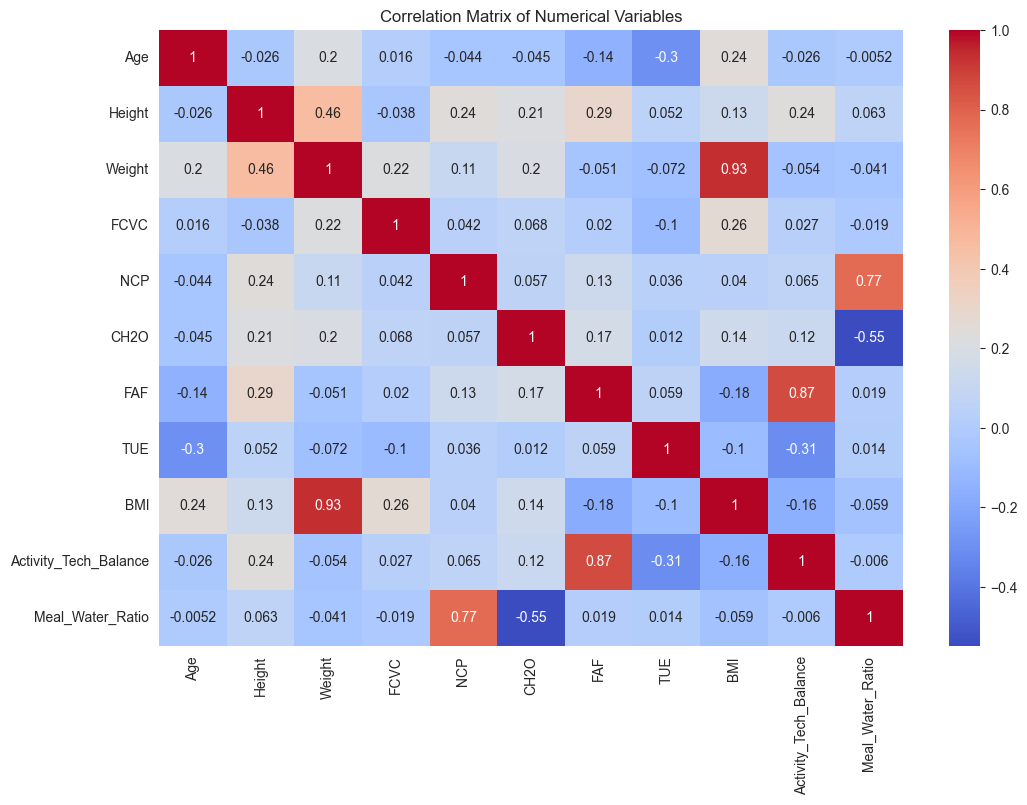

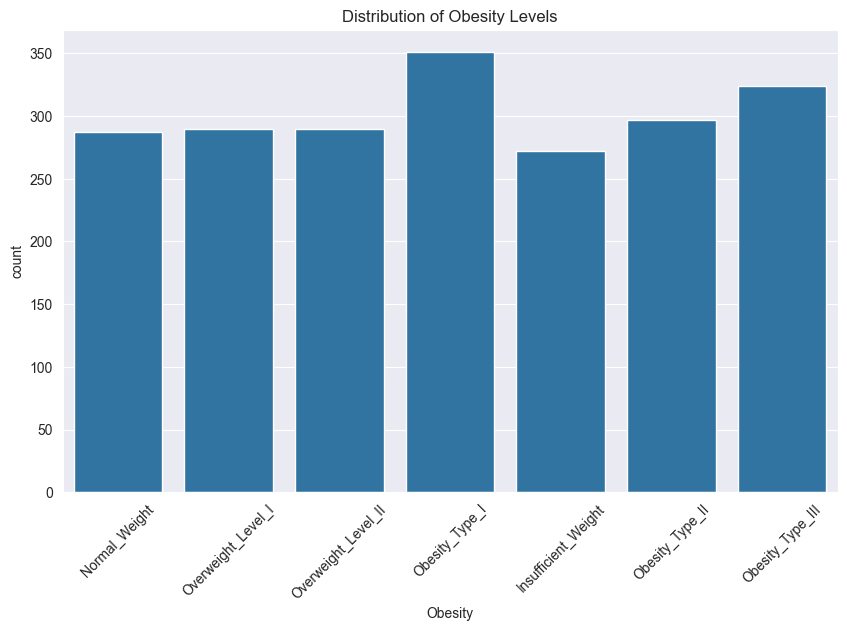

In [18]:
# Correlation matrix for numerical variables
numerical_columns = df.select_dtypes(include=['float64']).columns
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Distribution of obesity levels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Obesity')
plt.xticks(rotation=45)
plt.title('Distribution of Obesity Levels')
plt.show()

In [19]:
# Select features for the model
feature_columns = [col for col in df.columns if col.endswith('_encoded') and col != 'Obesity_encoded']
feature_columns.extend(['BMI', 'Activity_Tech_Balance', 'Meal_Water_Ratio',
                        'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

X = df[feature_columns]
y = df['Obesity_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-validation Score: 0.9944298538567949



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.98      1.00      0.99        62
           2       1.00      0.99      0.99        78
           3       0.98      1.00      0.99        58
           4       1.00      1.00      1.00        63
           5       1.00      1.00      1.00        56
           6       1.00      1.00      1.00        50

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



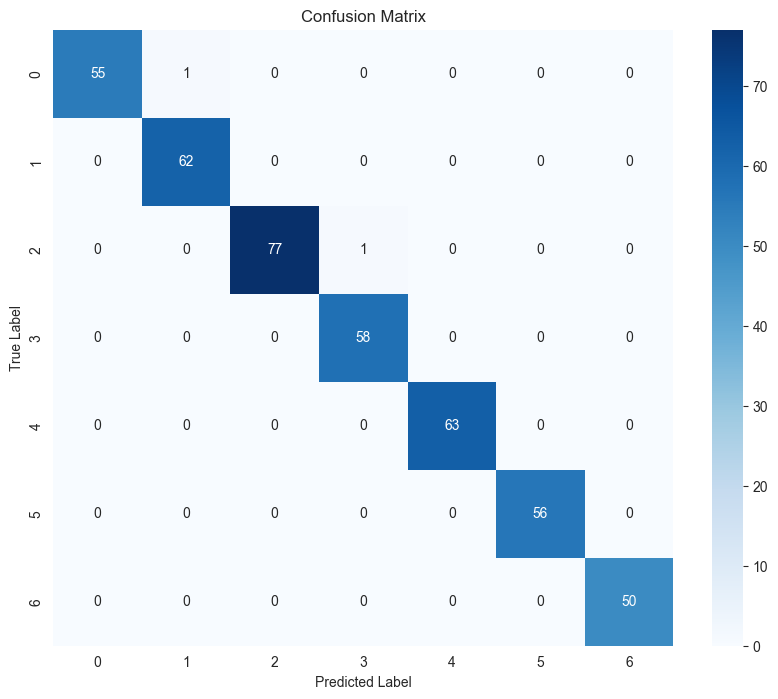

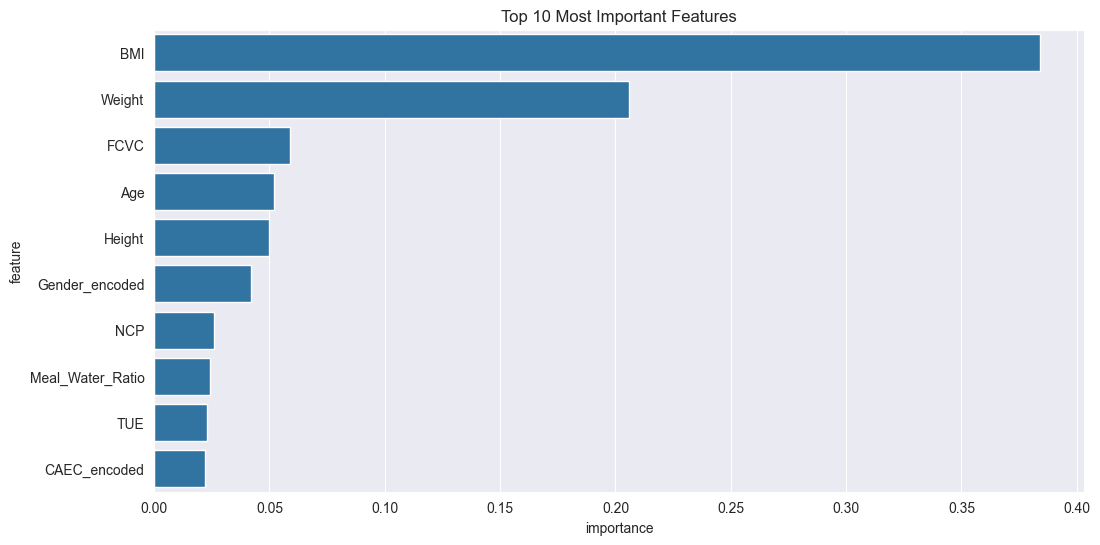

In [21]:
# Make predictions
y_pred = grid_search.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': grid_search.best_estimator_.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

In [22]:
# Calculate and display additional metrics
print("Model Performance Summary:")
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Training Score: {grid_search.score(X_train_scaled, y_train):.4f}")
print(f"Testing Score: {grid_search.score(X_test_scaled, y_test):.4f}")

# Display top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

Model Performance Summary:
Best Model Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Score: 1.0000
Testing Score: 0.9956

Top 5 Most Important Features:
   feature  importance
8      BMI    0.383979
13  Weight    0.206006
14    FCVC    0.059099
11     Age    0.051976
12  Height    0.049876
